# **SLDS MultiscrollScroll 3D 6states**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time as time
import random 
import reservoirpy.datasets as rsvp_d

from scipy.special import logsumexp
from scipy.stats import multivariate_normal, invwishart, matrix_normal

## Data generation

In [3]:
def Plot3D(xs, ys, zs, title, start, pt_number, lw):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    plt.show()
    


def Plot2D(xs, ys, zs, titl1, titl2, titl3, start, pt_number, lw):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 5))

    ax1.plot(xs[start:start+pt_number], ys[start:start+pt_number], lw=lw)
    ax1.set_title(titl1)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")

    ax2.plot(xs[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax2.set_title(titl2)
    ax2.set_xlabel("X Axis")
    ax2.set_ylabel("Z Axis")

    ax3.plot(ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax3.set_title(titl3)
    ax3.set_xlabel("Y Axis")
    ax3.set_ylabel("Z Axis")

    plt.show()

In [4]:
t1 = time.time() #times the computation
arr = rsvp_d.multiscroll(2500, a=40.0, b=3.0, c=28.0, x0=[- 0.1, 0.5, 20.6], h=0.01)
xs = arr[:,0]
ys = arr[:,1]
zs = arr[:,2]
t2 = time.time()
print ('computation takes ',t2-t1,' seconds.')

computation takes  0.07506179809570312  seconds.


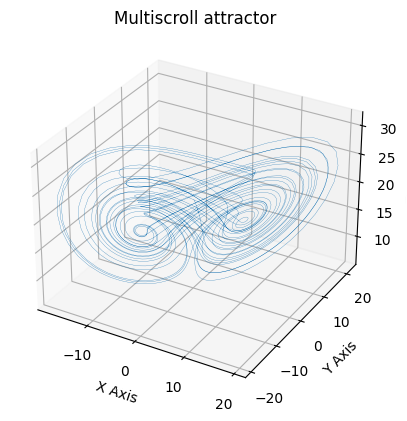

In [5]:
Plot3D(xs, ys, zs, "Multiscroll attractor", start=0, pt_number=2500, lw=0.2)

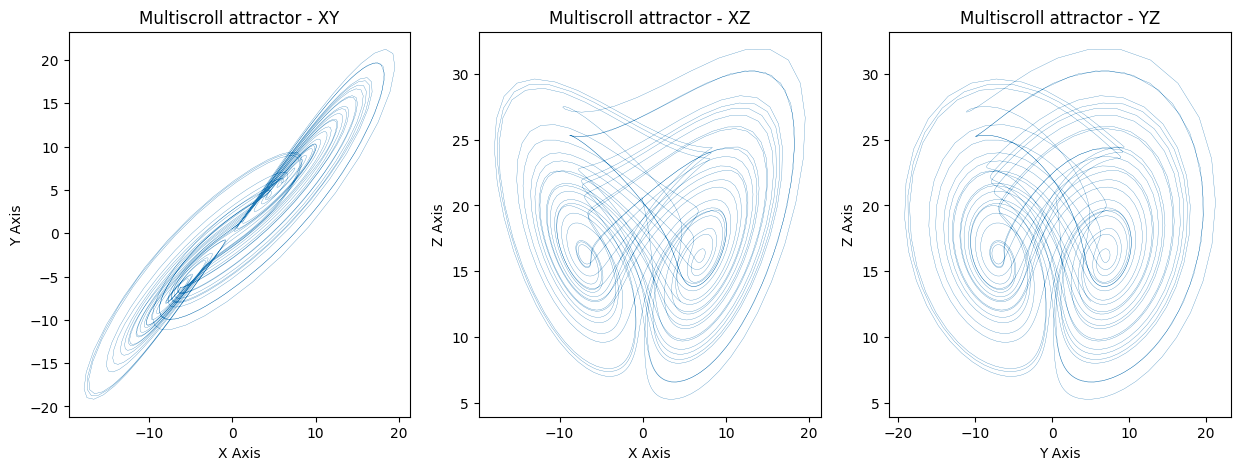

In [6]:
Plot2D(xs, ys, zs, "Multiscroll attractor - XY", "Multiscroll attractor - XZ", "Multiscroll attractor - YZ", start=0, pt_number=2500, lw=0.2)

In [7]:
y = arr[0:1000,0:3].copy()
y[:, 0] = y[:, 0]/20
y[:, 1] = y[:, 1]/20
y[:, 2] = y[:, 2]/20 - 1
y.shape

(1000, 3)

(-1.0, 1.0)

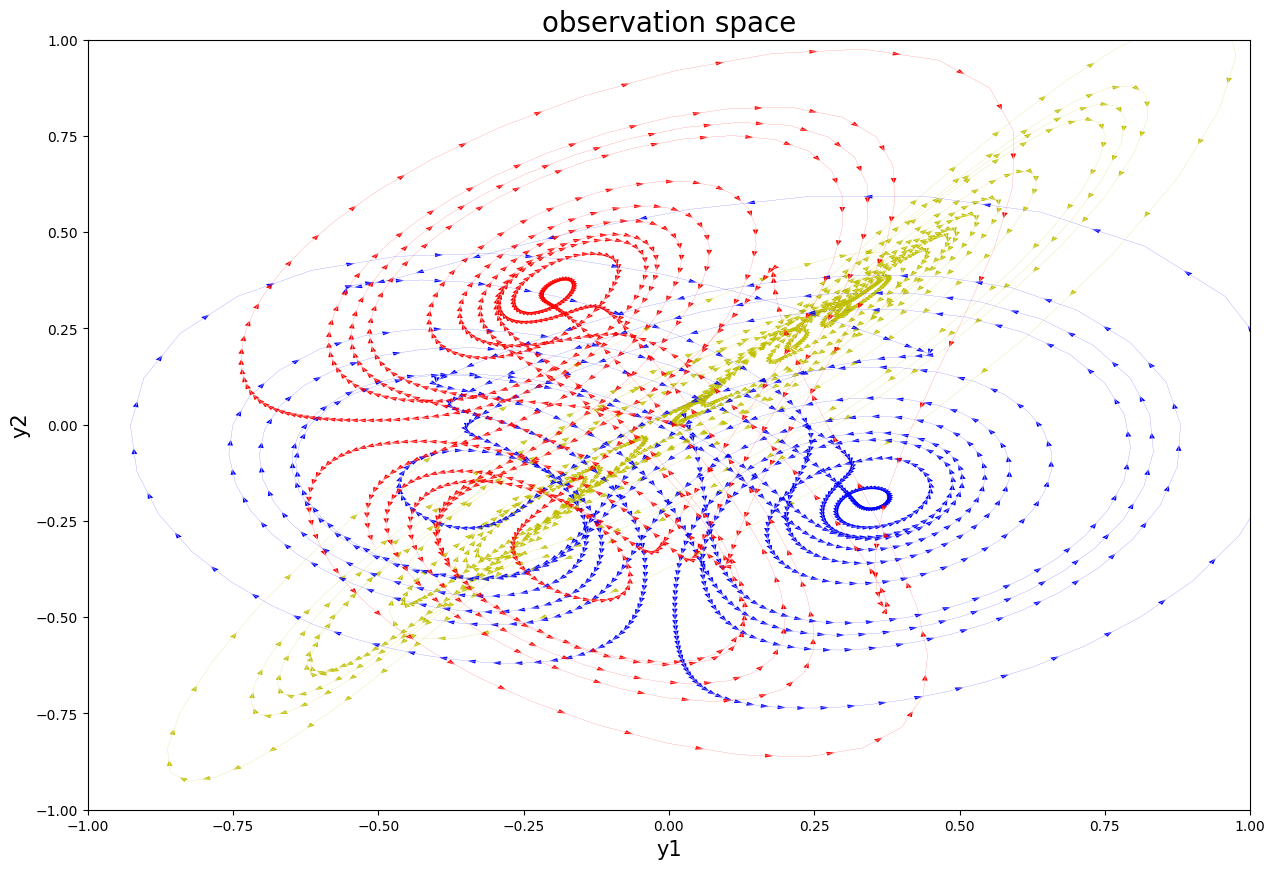

In [8]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1], lw = 0.1, color = "y")
plt.plot(y[:, 1], y[:, 2], lw = 0.1, color = "b")
plt.plot(y[:, 2], y[:, 0], lw = 0.1, color = "r")

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "y")
    
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 1], y[t+1, 1]])
    arr_mean_y2 = np.mean([y[t, 2], y[t+1, 2]])
    dy1 = y[t+1, 1] - y[t, 1]
    dy2 = y[t+1, 2] - y[t, 2]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "b")
    
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 2], y[t+1, 2]])
    arr_mean_y2 = np.mean([y[t, 0], y[t+1, 0]])
    dy1 = y[t+1, 2] - y[t, 2]
    dy2 = y[t+1, 0] - y[t, 0]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "r")
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [9]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [10]:
T = y.shape[0] # number of time steps
N = 3 # observation dim
K = 6 # latent dim

L = 40 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

S = np.array([1/120, 1/80, 1/100])*np.eye(N, N) # 1 meter in each direction
nu = N
C = 0.1*np.random.randn(N, N+1)
C[:, 0] = np.zeros(N)
C[:, 1:] = np.eye(N, N)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0][:, :, 0] = 1*np.random.randn(K, N)
A_hat_inf[0][:, :, 1:] = 1*np.random.randn(K, N, N)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([np.array([1/120, 1/80, 1/100])*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[ 8.12534220e-02  1.47834494e-01 -3.50921697e-01  9.94133313e-02]
  [-1.60087011e+00  7.77092375e-02  9.06974803e-01 -8.14223947e-01]
  [-1.84359949e+00 -5.27196492e-01  9.81172668e-01  3.55461477e-01]]

 [[-3.48702731e-02  3.70102660e-01 -6.94323118e-03  2.33977859e-01]
  [-7.65174653e-01  1.01518140e+00  5.20182107e-01  1.02463074e-01]
  [ 1.07785239e+00 -1.12811240e+00 -6.48142490e-01 -3.05214828e-01]]

 [[-7.97743317e-01  1.00040621e+00 -1.07254917e+00 -9.10765229e-01]
  [-2.06524400e+00  2.74843929e-01 -7.12085368e-01 -1.00338326e+00]
  [-7.07848586e-01 -1.71515526e+00 -2.53089428e-01  7.35288271e-04]]

 [[-9.28175083e-01  7.27313063e-01 -9.45727808e-01  1.87796227e+00]
  [-2.22159968e-01 -4.43294819e-01  2.99749952e-01 -2.74974058e-01]
  [-6.29089886e-01  5.20079006e-01 -1.18397998e+00 -6.02965936e-01]]

 [[-1.07536632e+00 -7.33929034e-01 -1.80703255e+00 -7.86326974e-01]
  [-3.58988956e-02 -1.54998859e-01 -1.03474739e+00 -3.62121772e-01]
  [ 6.04020286e-01  2.78844322e+00 -1.59

In [11]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

In [12]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):
    m = [np.array([1]*K)]
    log_m = [np.array([0]*K)]

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]
        
        for k in range(K):
            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # list of log messages

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [13]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in range(L-1):
    
    print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)


 SAMPLE: 0

 SAMPLE: 1

 SAMPLE: 2

 SAMPLE: 3

 SAMPLE: 4

 SAMPLE: 5

 SAMPLE: 6

 SAMPLE: 7

 SAMPLE: 8

 SAMPLE: 9

 SAMPLE: 10

 SAMPLE: 11

 SAMPLE: 12

 SAMPLE: 13

 SAMPLE: 14

 SAMPLE: 15

 SAMPLE: 16

 SAMPLE: 17

 SAMPLE: 18

 SAMPLE: 19

 SAMPLE: 20

 SAMPLE: 21

 SAMPLE: 22

 SAMPLE: 23

 SAMPLE: 24

 SAMPLE: 25

 SAMPLE: 26

 SAMPLE: 27

 SAMPLE: 28

 SAMPLE: 29

 SAMPLE: 30

 SAMPLE: 31

 SAMPLE: 32

 SAMPLE: 33

 SAMPLE: 34

 SAMPLE: 35

 SAMPLE: 36

 SAMPLE: 37

 SAMPLE: 38


In [14]:
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[10:], return_counts=True)
print(dict(zip(unique, counts)))

[0 2 1 4 3 0 5 5 4 5 2 0 5 1 1 0 3 5 0 0 0 0 3 4 2 0 4 2 3 3 4 5 2 0 4 4 5
 1 5 3 1 1 3 4 0 4 3 4 1 1 4 2 1 3 5 3 4 1 2 0 5 4 3 0 3 3 2 4 2 5 2 1 1 3
 0 3 0 0 5 1 1 0 2 3 0 2 5 5 5 3 2 1 0 5 0 4 4 3 3 0 0 1 1 1 0 5 2 4 0 2 1
 5 0 4 0 2 1 5 2 1 4 1 5 0 3 4 1 1 2 1 3 4 4 5 2 1 3 3 3 4 0 0 0 2 2 0 3 3
 1 1 1 3 4 1 1 5 0 4 0 5 3 5 3 3 2 3 0 0 1 5 5 3 0 5 2 0 4 5 2 0 3 4 1 0 3
 2 1 0 4 0 3 1 5 5 3 1 0 3 0 5 3 3 0 2 4 1 5 0 0 2 1 0 5 4 3 4 1 3 5 1 5 0
 2 0 0 0 4 3 4 5 2 4 5 2 3 3 1 1 0 3 5 2 0 1 4 1 5 0 3 2 4 2 4 4 4 0 5 4 3
 2 0 1 0 4 5 1 1 4 3 2 5 2 2 3 4 2 5 3 0 4 4 0 5 5 2 3 1 1 1 5 1 0 2 2 4 5
 4 1 4 0 5 3 0 4 0 0 0 2 5 1 2 4 5 0 3 5 3 0 2 4 0 2 1 1 1 0 3 5 4 2 4 2 5
 4 5 4 4 3 0 0 4 5 1 2 5 4 5 0 1 0 3 2 1 0 0 3 5 2 5 1 1 4 1 2 4 1 4 3 5 1
 5 4 3 5 4 4 3 0 1 4 3 2 4 3 0 2 5 2 4 2 2 2 5 1 2 5 4 0 0 1 0 4 2 4 0 2 0
 5 0 2 3 0 2 5 1 2 2 3 5 4 3 4 3 0 3 1 3 3 2 5 5 3 4 2 2 5 3 2 1 4 5 2 3 5
 0 5 4 2 4 2 5 1 3 2 5 5 0 5 2 2 5 4 1 2 3 3 0 1 4 0 4 2 2 2 5 2 0 4 4 5 2
 4 2 0 4 3 3 0 4 2 1 0 0 

In [15]:
print(np.mean(M_inf, axis = 0))
eigw_inf, eigv_inf = np.linalg.eig(np.mean(M_inf, axis = 0).T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0]))

[[0.15654146 0.17618227 0.17908221 0.13664134 0.15593664 0.19561608]
 [0.01052047 0.88699952 0.01786551 0.04377406 0.01021902 0.03062142]
 [0.08422555 0.11261836 0.47082716 0.09329335 0.10025276 0.13878281]
 [0.01848414 0.012347   0.01333044 0.84160573 0.09520232 0.01903036]
 [0.01138891 0.00512616 0.00727375 0.01832222 0.92775486 0.0301341 ]
 [0.00645324 0.02610598 0.00323529 0.00772821 0.01671395 0.93976334]]
[ 2.25701733e+15 -3.37799665e+14 -1.08643378e+15 -2.52989352e+14
 -2.56965649e+14 -3.22828882e+14]


In [16]:
print(np.mean(A_hat_inf, axis = 0))

[[[-2.82560858e-01  9.30581254e-01 -7.28724560e-02  1.94939873e-05]
  [-1.79806049e-01  6.23337803e-02  1.01181705e+00  1.19898415e-01]
  [-2.62393296e-01 -3.74589435e-02 -1.24609149e-01  1.00678131e+00]]

 [[-5.53887334e-02  9.63734162e-01  9.51871458e-02 -1.27325710e-01]
  [-4.50651231e-02 -3.80285437e-02  1.03858930e+00 -1.81684388e-01]
  [-2.26901775e-02  1.83980396e-02  9.65153179e-02  9.40409194e-01]]

 [[ 7.14843501e-03  9.85617049e-01 -1.95026655e-03 -2.50611868e-02]
  [-4.85961341e-02 -2.87741066e-02  9.63915609e-01 -2.85399654e-02]
  [-2.24239181e-02 -3.87206646e-02 -1.01591832e-02  9.78529659e-01]]

 [[-6.29990861e-02  8.23069866e-01  8.43241535e-02  9.80438142e-02]
  [-4.20693200e-02 -1.77182701e-01  1.04851809e+00  1.05531201e-01]
  [-6.27307387e-02 -4.41764516e-02 -1.17036469e-01  9.25364892e-01]]

 [[ 1.62177746e-03  9.03786728e-01  3.82660034e-02  6.42670428e-02]
  [ 2.25034930e-02 -6.00813014e-02  1.00946153e+00  8.55764094e-02]
  [-7.54904355e-03  6.97262131e-02 -8.11

In [17]:
Q_inf_av = np.mean(Q_inf, axis = 0)
for k in range(K):
    print(Q_inf_av[k])
    eigw_q, _ = np.linalg.eig(Q_inf_av[k])
    print(eigw_q)

[[0.3880294  0.22443859 0.13176923]
 [0.22443859 0.45949164 0.10342511]
 [0.13176923 0.10342511 0.24894058]]
[0.70980636 0.16202501 0.22463024]
[[0.00067066 0.00040897 0.00022892]
 [0.00040897 0.00097886 0.0001608 ]
 [0.00022892 0.0001608  0.00070315]]
[0.00136709 0.00035351 0.00063207]
[[ 0.00290361  0.00065774 -0.00019246]
 [ 0.00065774  0.00434963 -0.00091554]
 [-0.00019246 -0.00091554  0.00245867]]
[0.00494789 0.00268322 0.0020808 ]
[[ 1.31384073e-03  9.23653963e-04 -7.81547283e-05]
 [ 9.23653963e-04  1.37033996e-03 -5.37112292e-05]
 [-7.81547283e-05 -5.37112292e-05  6.09056269e-04]]
[0.00227138 0.00041615 0.00060572]
[[ 4.13715826e-04  1.51535763e-04 -5.35080710e-05]
 [ 1.51535763e-04  5.14733828e-04 -5.29391760e-05]
 [-5.35080710e-05 -5.29391760e-05  3.47485877e-04]]
[0.00064265 0.00029949 0.00033379]
[[2.96647744e-04 6.99922127e-05 1.84995796e-05]
 [6.99922127e-05 4.25578021e-04 1.27554459e-05]
 [1.84995796e-05 1.27554459e-05 3.16328976e-04]]
[0.00045884 0.00026323 0.00031648]


In [18]:
#b_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,0]
#A_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,1:]
b_inf_av = A_hat_inf[-1][:,:,0]
A_inf_av = A_hat_inf[-1][:,:,1:]

In [19]:
# Define the grid of x, y, z points
y = arr[:1000,0:3].copy()
y[:, 0] = y[:, 0]/11 - 0.1
y[:, 1] = y[:, 1]/10 + 0.1
y[:, 2] = y[:, 2]/11 - 1

z = z_inf[-1]
A = A_inf_av
b = b_inf_av
x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])
U = np.zeros((y.shape[0]))
V = np.zeros((y.shape[0]))
W = np.zeros((y.shape[0]))

# Define the vector field components
for l in range(y.shape[0]):
    k = z[l]
    U[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[0] + b[k, 0] - y[l, 0]
    V[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[1] + b[k, 1] - y[l, 1]
    W[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[2] + b[k, 2] - y[l, 2]

conversion = {0: "b",
              1: "r", 
              2: "y", 
              3: "g", 
              4: "m", 
              5: "c", 
              6: "k", 
              7: "0.2",
              8: "0.5",
              9: "0.8"}

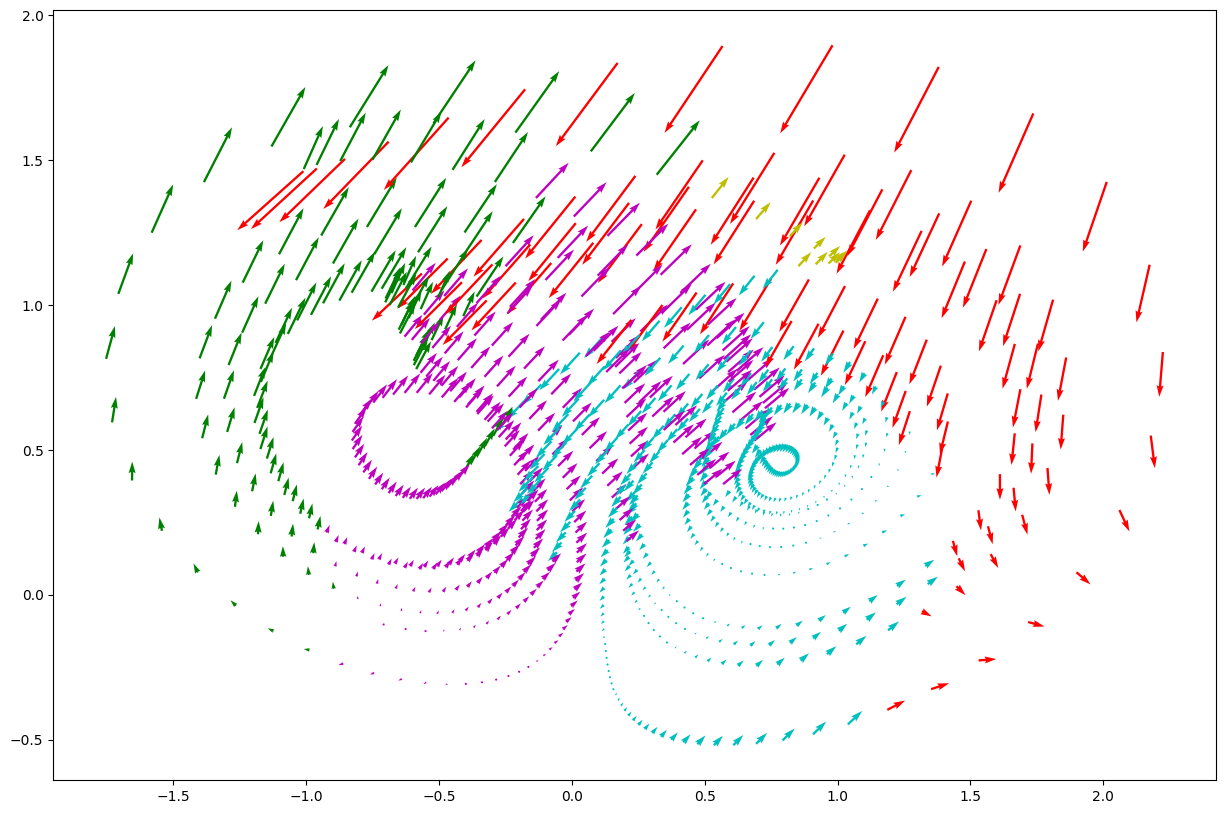

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')

# Plot the 3D vector field
ax.quiver(y[:, 1], y[:, 2], U, V, color = [conversion[i] for i in z], width = 2e-3)#, length=0.1, normalize=True, lw = 0.5)
plt.show()

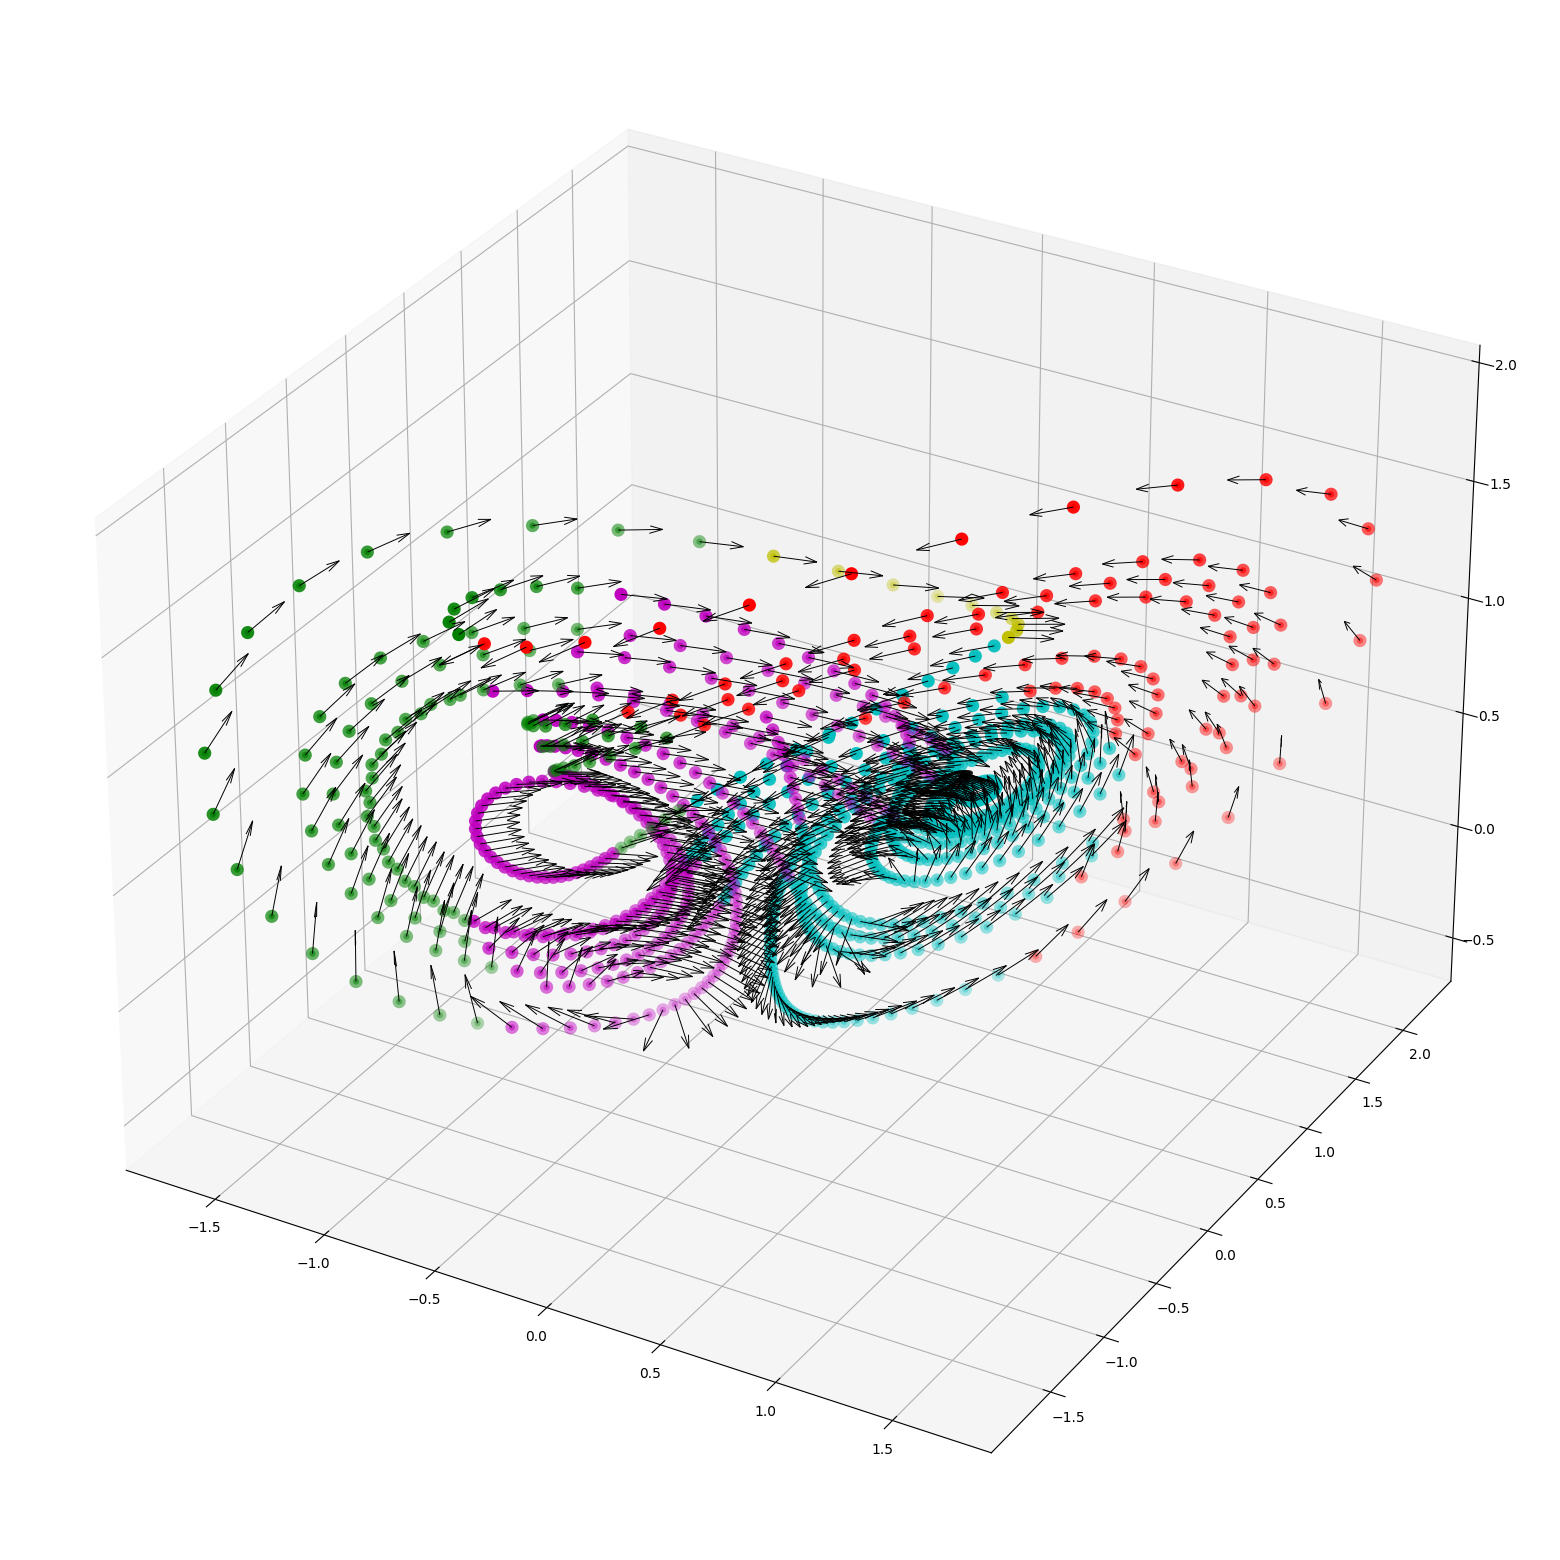

In [21]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D vector field
ax.quiver(y[:, 0], y[:, 1], y[:, 2], U, V, W, length= 2e-1, normalize=True, lw = 0.7, color = "k")
for i in range(K):
    ax.scatter(y[:, 0][z == i], y[:, 1][z == i], y[:, 2][z == i], color = conversion[i], lw = 5)
    
plt.show()